# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr,spearmanr
import os
from collections import Counter, defaultdict
import re
from random import choice
from itertools import groupby, chain
from operator import itemgetter
import os
from randseq.utils import revcomp, calculate_log2fc, allseqs, get_all_sites, flatten    
import ast

In [ ]:
#| hide
from randseq.example_data import get_example_data_dir

In [ ]:
#| hide
data_path=get_example_data_dir()
os.listdir(data_path)

['__init__.py', 'countsTable.csv', '__pycache__']

### 1. Computing the log2fc of the sequences from counts data

In [ ]:
counts_file="countsTable.csv"
file_path=os.path.join(data_path,counts_file)
counts=pd.read_csv(file_path, index_col=0)
counts = counts[[col for col in counts.columns if ("_T0" in col) or ("MFDpir" in col)]]

log2fc_df = calculate_log2fc(counts, reference_column='MFDpir', count_threshold=20, pseudocount=1)
log2fc_df

,K12_T0,HS_T0,E1114_T0,E1167_T0,H120_T0,TA054_T0,TA447_T0,E101_T0,41-1Ti9_T0,TA280_T0,M114_T0,TA249_T0,ROAR8_T0,JJ1886_T0,CFT073_T0,APECO1_T0,UTI89_T0,S88_T0,MG1655_T0
CGGAGGTACTGGGTACATTT,0.043818,0.049551,0.187868,-0.302314,0.238304,0.051836,0.186450,0.093344,0.029484,0.106924,-0.329062,-0.102645,0.144280,0.084854,0.212674,0.229591,-0.457070,0.213624,0.090458
TGGCGATAATGCCGGCTATC,0.045463,0.137127,0.437387,0.113014,0.137767,0.060845,0.063668,-0.014449,-0.008977,-0.025606,0.003605,0.084441,-0.167417,0.018354,0.041919,0.016410,-0.207488,0.092292,0.101627
TTCCAGTTCACTGGTCTTCG,-0.049694,0.049903,-0.105148,-0.061620,-0.081886,-0.072083,0.402207,0.087885,0.207649,0.127306,0.204781,-0.106153,-0.012804,0.285761,-0.167107,0.269887,0.182096,0.458076,0.128330
AATTTCAGTGCCGTTCAGAT,-0.251957,-0.422224,-0.224591,-0.058728,-0.204575,-0.192908,-0.220676,-0.143054,-0.277042,-0.205084,0.058866,-0.064442,-0.029019,-0.042375,-0.095307,-0.254714,0.460256,-0.183890,-0.180938
CTGCGGTAATAATTCCCGCC,-0.178427,-0.154025,0.581087,0.401967,0.047002,-0.309751,-0.200689,-0.292042,-0.473919,-0.298991,-0.221896,-0.060500,0.085888,-0.279165,-0.206676,-0.097563,-0.347949,-0.188758,-0.186226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCTTGATGTAGCCTTCGAAC,-0.100518,-0.079966,0.027302,-0.268222,-0.337706,-0.047079,-0.072379,-0.246364,-0.250380,-0.142468,-0.091826,-0.004635,0.260965,-0.174715,0.278843,-0.206298,-0.319604,-0.055837,-0.133185
TAATGGCAAATTGACACTCC,0.258205,0.103683,0.428049,-0.106268,0.247864,0.050536,0.240706,0.133009,0.195027,0.096144,0.482377,-0.168566,-0.008969,0.224936,0.009979,0.217354,0.453491,0.201961,0.387054
GCTGCGCGCGGAGTTGTTCC,-0.629856,-0.381054,-0.431536,-0.328063,-0.461695,-0.258496,-0.442414,-0.358037,-0.372732,-0.359784,-0.581490,0.174623,-0.984388,-0.273490,-0.490203,-0.122278,-0.562652,-0.497605,-0.959646
GCAACACGCCAGTAAGGTGT,0.693416,0.487153,0.744586,-0.054785,0.474863,0.585146,0.162493,0.388078,0.733043,0.280496,0.167936,0.605561,0.400524,0.051808,0.422091,0.098976,0.294288,0.064457,0.376418


### 2. Obtaining the sequence context of the variable sequence to identify sites at the boundaries of the variable sequence

In [ ]:
#| export
def get_lib_seq_context(seqs,left,right):
    """
    Generates a list of sequences by combining a left and right sequence with each sequence in the input list.
    
    Args:
        seqs (list): List of sequences to be combined.
        left (str): Left sequence to prepend.
        right (str): Right sequence to append.

    Returns:
        list: List of combined sequences.
    """
    left=left.upper()
    right=right.upper()
    lib=[left+r+right for r in seqs]
    return lib


In [ ]:
left, right = "GTCCTAGGTATAATACTAGT", "GTTTTAGAGCTAGAAATAGC"
lib=get_lib_seq_context(log2fc_df.index,left,right)
lib[:5]

['GTCCTAGGTATAATACTAGTCGGAGGTACTGGGTACATTTGTTTTAGAGCTAGAAATAGC',
 'GTCCTAGGTATAATACTAGTTGGCGATAATGCCGGCTATCGTTTTAGAGCTAGAAATAGC',
 'GTCCTAGGTATAATACTAGTTTCCAGTTCACTGGTCTTCGGTTTTAGAGCTAGAAATAGC',
 'GTCCTAGGTATAATACTAGTAATTTCAGTGCCGTTCAGATGTTTTAGAGCTAGAAATAGC',
 'GTCCTAGGTATAATACTAGTCTGCGGTAATAATTCCCGCCGTTTTAGAGCTAGAAATAGC']

### 3. Listing all the sequence motifs found in our library that follow a specific pattern 

The pattern is a list of 3 numbers:
1. The number of defined bases in the first part of the site  
2. The number of undefined bases in the middle  
3. The number of defined bases in the second part of the site

In [ ]:
#| export
     
def get_sites_in_seq(lib,pattern=(3,6,4),no_ori=True):
    '''Computes the list of unique sites matching the pattern present in each sequence of the library
    The pattern is a list of 3 number:
        1. The number of defined bases in the first part of the site
        2. The number of undefined bases in the middle
        3. The number of defined bases in the second part of the site
    '''
    #Checks all sequences are the same size
    if len(set([len(s) for s in lib]))!=1:
        return 'not all sequences in library are the same size'
    
    L=len(lib[0])
    
    if len(pattern)>L:
        return 'site specifications are longer than the sequence provided'
    
    
    set_list=[]
    for seq in lib:
        sites=re.findall("(?=([ATGC]{{{}}})([ATGC]{{{}}})([ATGC]{{{}}}))".format(pattern[0],pattern[1],pattern[2]),seq)
        if no_ori==True:
            rev=revcomp(seq)
            sites+=re.findall("(?=([ATGC]{{{}}})([ATGC]{{{}}})([ATGC]{{{}}}))".format(pattern[0],pattern[1],pattern[2]),rev)
        set_list.append(set([s1+'N'*pattern[1]+s3 for s1,s2,s3 in sites]))

    return set_list

In [ ]:

lib=get_lib_seq_context(log2fc_df.index,left,right)
sites_in_seq=get_sites_in_seq(lib,pattern=(3,6,4),no_ori=True)
assert len(sites_in_seq) == len(lib)
print(f"First 5 pattern matching sequences found in the first sequence of the library:")
list(sites_in_seq[0])[:5]

First 5 pattern matching sequences found in the first sequence of the library:


['AGCNNNNNNTAGC',
 'CTGNNNNNNTTTG',
 'TAGNNNNNNAAAT',
 'ACTNNNNNNATTT',
 'ACANNNNNNCCCA']

In [ ]:
#| export
def score(FCs, thr=-1):
    """
    Returns the fraction of sequences depleted below the thr value.
    Handles empty lists of FCs by returning 0.
    """
    if len(FCs)==0:  # Check if the list is empty
        return 0.0
    return sum([x < thr for x in FCs]) / len(FCs)

In [ ]:
assert score([-2,-0.5,-0.1,-5],thr=-1) == 0.5

In [ ]:
#| export
def identify_depleted_motifs_scanning_ends(log2fc_series, 
                                           scan_depth_k=6, 
                                           max_motif_length=6, 
                                           depletion_threshold=-1, 
                                           score_thr=0.85, 
                                           min_sequence_support=5):
    """
    Identifies DNA motifs associated with sequence depletion by scanning k positions
    from both the left and right ends of sequences, using a pandas Series of log2FC values.

    Args:
        log2fc_series (pd.Series): pandas Series with sequences (DNA strings) as index
                                   and log2FC values as data.
        scan_depth_k (int): The number of positions to scan from each end (0 to k inclusive).
        max_motif_length (int): The maximum length of the motif to consider.
        depletion_threshold (float): The log2FC threshold for considering a sequence depleted.
        min_sequence_support (int): The minimum number of sequences (strictly greater than this value)
                                    a motif must be found in to be included in the results.

    Returns:
        pd.DataFrame: A DataFrame with identified motifs, their length, actual 0-indexed position,
                      number of occurrences, average log2FC, and depletion score (fraction_depleted).
                      Sorted by primary depletion metrics.
    """
    if not isinstance(log2fc_series, pd.Series):
        print(f"Error: Input must be a pandas Series.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    if log2fc_series.empty:
        print(f"Error: Input Series is empty.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    current_log2fc_series = pd.to_numeric(log2fc_series.copy(), errors='coerce')
    series_name = current_log2fc_series.name if current_log2fc_series.name else "input Series"
    print(f"Analyzing motifs of length 1 to {max_motif_length}, scanning positions 0 to {scan_depth_k} from each end, for {series_name}.")
    print(f"Minimum sequence support for a motif: > {min_sequence_support} (i.e., {min_sequence_support +1} or more)")


    motif_stats_accumulator = {}

    # Iterate over (sequence_string, log2fc_value) pairs
    for seq_str, log2fc_val in current_log2fc_series.items(): 
        if pd.isna(log2fc_val) or not isinstance(seq_str, str):
            continue

        processed_positions_for_this_seq = set() 
        for motif_len in range(1, max_motif_length + 1):
            if len(seq_str) < motif_len:
                continue

            # Left scans
            for j_offset in range(scan_depth_k + 1):
                actual_pos_left = j_offset
                if actual_pos_left + motif_len <= len(seq_str):
                    if (actual_pos_left, motif_len) not in processed_positions_for_this_seq:
                        motif = seq_str[actual_pos_left : actual_pos_left + motif_len]
                        key = (motif, actual_pos_left, motif_len) 
                        if key not in motif_stats_accumulator:
                            motif_stats_accumulator[key] = []
                        motif_stats_accumulator[key].append(log2fc_val)
                        processed_positions_for_this_seq.add((actual_pos_left, motif_len))

            # Right scans
            for j_offset in range(scan_depth_k + 1):
                actual_pos_right = len(seq_str) - motif_len - j_offset
                if actual_pos_right >= 0 and actual_pos_right + motif_len <= len(seq_str):
                    if (actual_pos_right, motif_len) not in processed_positions_for_this_seq:
                        motif = seq_str[actual_pos_right : actual_pos_right + motif_len]
                        key = (motif, actual_pos_right, motif_len) 
                        if key not in motif_stats_accumulator:
                            motif_stats_accumulator[key] = []
                        motif_stats_accumulator[key].append(log2fc_val)
                        processed_positions_for_this_seq.add((actual_pos_right, motif_len))
    
    if not motif_stats_accumulator:
        print("No motifs found or no valid data to process based on scan parameters.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    # Use a list comprehension for conciseness
    results = [
        {
            'motif': key[0],             # motif_str
            'length': key[2],            # motif_len
            'position': key[1],          # actual_pos
            'num_sequences': len(fc_values_list), 
            'avg_log2fc': np.mean(fc_values_list),
            'fraction_depleted': score(fc_values_list, depletion_threshold)
        }
        for key, fc_values_list in motif_stats_accumulator.items()
        if len(fc_values_list) > min_sequence_support # Apply min_sequence_support filter
    ]
    
    if not results:
        print(f"No motifs found meeting the minimum sequence support of > {min_sequence_support}.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(
        by=['fraction_depleted', 'avg_log2fc', 'num_sequences'],
        ascending=[False, True, False]
    )
    results_df = results_df.loc[results_df['fraction_depleted'] > score_thr]
    return results_df

In [ ]:
depleted_motifs_df=identify_depleted_motifs_scanning_ends(log2fc_df["JJ1886_T0"])
depleted_motifs_df.head(10)

Analyzing motifs of length 1 to 6, scanning positions 0 to 6 from each end, for JJ1886_T0.
Minimum sequence support for a motif: > 5 (i.e., 6 or more)


,motif,length,position,num_sequences,avg_log2fc,fraction_depleted
8695,AAAAG,5,11,10,-5.662158,1.0
22013,GTGCGG,6,0,6,-5.490821,1.0
12567,AAAGT,5,12,13,-5.262390,1.0
12568,CAAAG,5,11,16,-5.201596,1.0
17472,GTGCG,5,0,10,-5.107176,1.0
2571,AAAG,4,12,42,-5.076919,1.0
2580,AAAGC,5,12,9,-5.029139,1.0
17128,AAAGA,5,12,13,-4.996286,1.0
10197,GTGTC,5,0,6,-4.959089,1.0
23364,AAAGG,5,12,7,-4.943650,1.0


In [ ]:
#| export
def filter_to_core_motifs(depleted_motifs_df, 
                          score_improvement_margin=0.05):
    """
    Filters a DataFrame of depleted motifs to identify underlying "core" motifs.
    A longer motif is kept only if it's significantly better than a shorter core motif it contains.

    Args:
        depleted_motifs_df (pd.DataFrame): DataFrame from identify_depleted_motifs_scanning_ends.
        score_improvement_margin (float): A longer motif's 'fraction_depleted' must be
                                          greater than the core motif's score by this margin.
        fc_improvement_margin (float): A longer motif's 'avg_log2fc' must be lower
                                       than the core motif's avg_log2fc by this margin.

    Returns:
        pd.DataFrame: A filtered DataFrame containing potentially core motifs.
    """
    if depleted_motifs_df.empty:
        return pd.DataFrame(columns=depleted_motifs_df.columns)

    sorted_df = depleted_motifs_df.sort_values(
        by=['length','fraction_depleted'],
        ascending=[True, False]
    ).reset_index(drop=True)

    core_motifs_list = []
    
    for idx, candidate_row in sorted_df.iterrows():
        candidate_motif = candidate_row['motif']
        candidate_pos = candidate_row['position']
        candidate_len = candidate_row['length']
        candidate_score = candidate_row['fraction_depleted']
        
        is_subsumed = False
        for core_dict in core_motifs_list: 
            core_motif = core_dict['motif']
            core_pos = core_dict['position']
            core_len = core_dict['length']
            core_score = core_dict['fraction_depleted']
            
            if core_len < candidate_len and core_motif in candidate_motif:    
                relative_start = candidate_motif.find(core_motif)
                if candidate_pos + relative_start == core_pos:
                    significantly_better_score = candidate_score >= core_score - score_improvement_margin
                        
                    if significantly_better_score:
                        is_subsumed = True
                        break 
        
        if not is_subsumed:
            core_motifs_list.append(candidate_row.to_dict())
            
    if not core_motifs_list:
         return pd.DataFrame(columns=depleted_motifs_df.columns)
    return pd.DataFrame(core_motifs_list)



In [ ]:
depleted_motifs_df=filter_to_core_motifs(depleted_motifs_df)
depleted_motifs_df.head(10)

,motif,length,position,num_sequences,avg_log2fc,fraction_depleted
0,GTG,3,0,187,-4.764500,1.0
1,AAAG,4,12,42,-5.076919,1.0


In [ ]:
#| export
def get_fold_change_values_per_site(site_sets_list, fold_changes_list):
    """
    Computes a dictionary mapping each unique site to a list of its associated
    log2 Fold Change (FC) values.

    Args:
        site_sets_list (list): A list of sets, where each set contains the sequence motifs found in a member of the library.
        fold_changes_list (list): A list of log2FC values, corresponding to each
                                  sequence in the library.

    Returns:
        dict: A dictionary where keys are sequence motifs and values are numpy arrays
              containing the log2FC values associated with that site.
    """

    # Step 1: Create a flat list of (site, FC_value) pairs
    # Each site within a set is associated with that set's FC value.
    site_fc_pairs_nested = [
     [(site, fc_value) for site in site_set]
     for site_set, fc_value in zip(site_sets_list, fold_changes_list)
     ]
    site_fc_pairs = list(chain.from_iterable(site_fc_pairs_nested)) # Standard way to flatten

    # Step 2: Sort the pairs by site to prepare for grouping
    # Sorting is essential for groupby to work correctly.
    site_fc_pairs.sort(key=itemgetter(0)) # Sorts by the first element (site)

    # Step 3: Group by site and collect FC values
    site_to_fcs_map = {}
    for site, group in groupby(site_fc_pairs, key=itemgetter(0)):
        # group is an iterator of (site, fc_value) tuples for the current site
        # Extract the FC value (the second element) from each pair in the group
        fcs_for_site = np.array([fc_value for current_site, fc_value in group])
        site_to_fcs_map[site] = fcs_for_site

    return site_to_fcs_map


In [ ]:
pattern=(3,6,4)
set_list=get_sites_in_seq(lib,pattern=pattern,no_ori=True)
site_FCs=get_fold_change_values_per_site(set_list,log2fc_df["JJ1886_T0"].values)
site_FCs["AGCNNNNNNGGGA"]


array([ 0.02025893, -0.15083807,  0.19052559,  0.04266223,  0.22493562,
       -0.13188093,  0.0203179 ,  0.10373391, -0.18265707,  0.24137364,
       -0.10160173,  0.5539999 ,  0.19568499,  0.29179059, -0.02109236,
       -0.46896125,  0.00812423])

In [ ]:
#| export
def filter_sequences_without_core_motifs(log2fc_series, core_motifs_df):
    """
    Filters an original log2fc Series to remove sequences that contain 
    any of the specified core motifs.

    Args:
        log2fc_series (pd.Series): Series with sequences as its index and log2FC values.
        core_motifs_df (pd.DataFrame): DataFrame of core motifs, must include
                                       'motif', 'position', and 'length' columns.

    Returns:
        pd.Series: A new Series containing only sequences (and their log2FC values)
                   from log2fc_series that do not carry any of the core motifs.
    """
    if not isinstance(log2fc_series, pd.Series) or log2fc_series.empty:
        # print("Info: log2fc_series is empty or not a Series. Returning a copy.")
        return log2fc_series.copy() 
    
    expected_core_motif_cols = ['motif', 'position', 'length']
    if not isinstance(core_motifs_df, pd.DataFrame) or core_motifs_df.empty or \
       not all(col in core_motifs_df.columns for col in expected_core_motif_cols):
        print("Info: core_motifs_df is empty or invalid for filtering. Returning original log2fc_series.")
        return log2fc_series.copy()

    # Create a boolean mask, True for sequences to keep
    sequences_to_keep_mask = pd.Series(True, index=log2fc_series.index)

    # Iterate through each unique sequence string in the original Series' index
    # Using .loc for assignment to the mask handles duplicate indices in the original Series correctly
    for seq_str_to_check in log2fc_series.index.unique(): 
        if not isinstance(seq_str_to_check, str): 
            continue # Skip if index label is not a string
        
        # Check this sequence against all core motifs
        for _, motif_row in core_motifs_df.iterrows():
            motif_str = motif_row['motif']
            try:
                position = int(motif_row['position'])
                motif_len = int(motif_row['length'])
            except (ValueError, TypeError):
                # print(f"Warning: Invalid position/length for motif {motif_str} in core_motifs_df. Skipping this motif.")
                continue 

            if not isinstance(motif_str, str) or not motif_str: 
                continue

            if len(seq_str_to_check) >= position + motif_len:
                if seq_str_to_check[position : position + motif_len] == motif_str:
                    # If a motif is found, mark all occurrences of this sequence string for removal
                    sequences_to_keep_mask.loc[log2fc_series.index == seq_str_to_check] = False 
                    break # Move to the next unique sequence_str_to_check

    return log2fc_series[sequences_to_keep_mask]

In [ ]:
filted_log2fc_df = filter_sequences_without_core_motifs(log2fc_df, depleted_motifs_df)

In [ ]:
#| export
def get_sites_scores(site_FCs, pattern, log2FC_thr=-1):
    """ 
    Scores sites based on depletion and occurrence.
    Returns a pandas DataFrame with 'site', 'fraction_depleted', 'num_sequences', 'avg_log2fc'.
    """
    site_scores_list = []
    
    for site_key, fc_values in site_FCs.items():
        if not isinstance(fc_values, (list, np.ndarray)) or len(fc_values) == 0:
            continue # Skip if fc_values is not a list/array or is empty
            
        current_score = score(fc_values, log2FC_thr)
        num_occurrences = len(fc_values)
        avg_fc = np.mean(fc_values) if num_occurrences > 0 else np.nan
        
        site_scores_list.append({
            'motif': site_key,
            'fraction_depleted': current_score,
            'num_sequences': num_occurrences,
            'avg_log2fc': avg_fc
        })
            
    if not site_scores_list:
        return pd.DataFrame(columns=['motif', 'fraction_depleted', 'num_sequences', 'avg_log2fc'])
    return pd.DataFrame(site_scores_list)

In [ ]:
site_scores = get_sites_scores(site_FCs,pattern)
site_scores.sort_values(by=['fraction_depleted', 'num_sequences'], ascending=[False, False]).head(10)

,motif,fraction_depleted,num_sequences,avg_log2fc
2652,AGGNNNNNNCCTC,1.000000,1,-4.601867
8786,GAGNNNNNNCCCC,1.000000,1,-1.406262
4410,CACNNNNNNATTA,0.958974,195,-4.569183
952,AATNNNNNNGTGC,0.826923,52,-3.962960
953,AATNNNNNNGTGG,0.815385,65,-3.883041
12519,TAANNNNNNTGTG,0.785714,238,-3.746732
951,AATNNNNNNGTGA,0.771429,70,-3.628320
8882,GAGNNNNNNGTCT,0.750000,4,-4.012801
954,AATNNNNNNGTGT,0.740741,54,-3.485249
11042,GGTNNNNNNAGGA,0.666667,3,-2.235343


In [ ]:
#| export
def filter_to_core_flexible_motifs(flexible_motifs_df, score_margin=0.05):
    """
    Filters a DataFrame of flexible (position-independent) motifs to identify underlying "core" motifs.
    A longer/more complex motif is removed if its score is not significantly better than a simpler
    core motif pattern it contains.

    Args:
        flexible_motifs_df (pd.DataFrame): DataFrame with 'site', 'pattern' (string like '(3,4,4)'),
                                           'fraction_depleted', 'num_sequences', 'avg_log2fc'.
        score_margin (float): A more complex motif is subsumed if its 'fraction_depleted'
                              is not better than (core_score - score_margin).
                              Effectively, if candidate_score >= core_score - score_margin, it's subsumed.

    Returns:
        pd.DataFrame: A filtered DataFrame containing potentially core flexible motifs.
    """
    if not isinstance(flexible_motifs_df, pd.DataFrame) or flexible_motifs_df.empty:
        return pd.DataFrame(columns=flexible_motifs_df.columns)

    # Ensure required columns exist
    required_cols = ['motif', 'pattern', 'fraction_depleted', 'avg_log2fc', 'num_sequences']
    if not all(col in flexible_motifs_df.columns for col in required_cols):
        print("Warning (filter_to_core_flexible_motifs): DataFrame missing required columns. Returning original.")
        return flexible_motifs_df.copy()

    # 1. Parse 'pattern' string and add helper columns
    df = flexible_motifs_df.copy()
    try:
        df['pattern_tuple'] = df['pattern'].apply(ast.literal_eval)
        df['p0'] = df['pattern_tuple'].apply(lambda x: x[0])
        df['p1_Ns'] = df['pattern_tuple'].apply(lambda x: x[1])
        df['p2'] = df['pattern_tuple'].apply(lambda x: x[2])
        df['defined_len'] = df['p0'] + df['p2']
    except Exception as e:
        print(f"Error parsing 'pattern' column in filter_to_core_flexible_motifs: {e}. Returning original DataFrame.")


    # 2. Sort by simplicity then score
    sorted_df = df.sort_values(
        by=['p1_Ns', 'defined_len', 'fraction_depleted', 'avg_log2fc', 'num_sequences'],
        ascending=[True, True, False, True, False]
    ).reset_index(drop=True)

    core_flex_list = []
    for _, candidate_row in sorted_df.iterrows():
        cand_site = candidate_row['motif']
        cand_p0, cand_p1_Ns, cand_p2 = candidate_row['p0'], candidate_row['p1_Ns'], candidate_row['p2']
        cand_score = candidate_row['fraction_depleted']
        # cand_avgfc = candidate_row['avg_log2fc'] # Not used in this subsumption logic for now

        is_subsumed = False
        for core_dict in core_flex_list: # Compare with already accepted core motifs
            core_site = core_dict['motif']
            core_p0, core_p1_Ns, core_p2 = core_dict['p0'], core_dict['p1_Ns'], core_dict['p2']
            core_score = core_dict['fraction_depleted']
            # core_avgfc = core_dict['avg_log2fc']

            # Simplicity check: core must be simpler than candidate
            is_simpler = (core_p0 + core_p2 <= cand_p0 + cand_p2) 
            if is_simpler:
                # Containment check: Does candidate_site contain the core_site pattern?
                # Convert core_site to a regex where Ns are wildcards
                core_site_part1 = core_site[0:core_p0]
                core_site_part2 = core_site[core_p0 + core_p1_Ns : core_p0 + core_p1_Ns + core_p2]
                
                core_regex_parts = []
                if core_p0 > 0: core_regex_parts.append(re.escape(core_site_part1))
                if core_p1_Ns > 0: core_regex_parts.append(f"[ATGCN]{{{core_p1_Ns}}}") # Match any base for Ns
                if core_p2 > 0: core_regex_parts.append(re.escape(core_site_part2))
                core_regex = "".join(core_regex_parts)
                if core_regex: # Ensure regex is not empty
                    try:
                        if re.search(core_regex, cand_site):
                            is_subsumed = True
                            break 
                        if re.search(core_regex, revcomp(cand_site)):
                            is_subsumed = True
                            break

                    except re.error:
                        # print(f"Regex error for core pattern: {core_regex}")
                        continue # Skip this core if its regex is bad
                
        
        if not is_subsumed:
            # Add original columns, not the temporary ones, to the list
            core_flex_list.append(candidate_row.to_dict())

    if not core_flex_list:
        return pd.DataFrame(columns=flexible_motifs_df.columns)
    
    return pd.DataFrame(core_flex_list)[flexible_motifs_df.columns]

In [ ]:
def analyze_motif_pipeline(log2fc_series, 
                           left_context_str, 
                           right_context_str, 
                           fixed_motif_scan_depth_k=0,
                           fixed_motif_max_length=6,
                           fixed_motif_depletion_thr=-1,
                           fixed_motif_score_thr=0.8,
                           fixed_motif_min_support=5,
                           core_motif_score_margin=0.05, # For fixed motifs
                           flexible_motif_patterns=[(6,0,0),(3,4,4)], 
                           flexible_motif_log2fc_thr=-1,
                           flexible_motif_min_support=5,
                           flexible_motif_score_thr=0.8,
                           core_flexible_motif_score_margin=0.05 # For flexible motifs
                           ):
    """
    Full pipeline to identify fixed-position core motifs and then position-independent motifs
    (from a list of patterns) in the remaining sequences (with context for flexible search).
    """
    print("--- Starting Fixed-Position Motif Analysis (on original short sequences) ---")
    depleted_fixed_motifs_df = identify_depleted_motifs_scanning_ends(
        log2fc_series, 
        scan_depth_k=fixed_motif_scan_depth_k,
        max_motif_length=fixed_motif_max_length,
        depletion_threshold=fixed_motif_depletion_thr,
        score_thr=fixed_motif_score_thr,
        min_sequence_support=fixed_motif_min_support
    )
    core_fixed_motifs_df = filter_to_core_motifs( 
        depleted_fixed_motifs_df,
        score_improvement_margin=core_motif_score_margin
    )
    if core_fixed_motifs_df.empty:
        print("No core motifs found at fixed positions.")
    else:
        print(f"Found {len(core_fixed_motifs_df)} core motifs at fixed positions:")
        for _, row in core_fixed_motifs_df.iterrows():
            print(f"  - Fixed Motif: {row['motif']}, Pos: {row['position']}, Len: {row['length']}, FracDep: {row['fraction_depleted']:.2f}, AvgFC: {row['avg_log2fc']:.2f}, N: {row['num_sequences']}")

    print("\n--- Starting Position-Independent Motif Analysis on Filtered Sequences (with context) ---")
    log2fc_series_for_flexible_analysis = filter_sequences_without_core_motifs(
        log2fc_series, 
        core_fixed_motifs_df 
    )
    if len(log2fc_series_for_flexible_analysis) == len(log2fc_series):
        print("No sequences were filtered out based on fixed-position core motifs (or no core motifs found).")
    else:
        print(f"Filtered log2fc_series for flexible analysis: {len(log2fc_series_for_flexible_analysis)} sequences remaining.")

    if log2fc_series_for_flexible_analysis.empty:
        print("No sequences remaining for flexible motif analysis after filtering.")
        flexible_motifs_results_df = pd.DataFrame(columns=['motif', 'pattern', 'fraction_depleted', 'num_sequences', 'avg_log2fc']) 
        return core_fixed_motifs_df, flexible_motifs_results_df

    short_sequences_for_flex_analysis = log2fc_series_for_flexible_analysis.index.tolist()
    sequences_with_context_for_flex = get_lib_seq_context(
        short_sequences_for_flex_analysis, 
        left_context_str, 
        right_context_str
    )
    fc_values_for_flexible_analysis = log2fc_series_for_flexible_analysis.tolist()
    
    all_flexible_motifs_data_list = [] 

    if not isinstance(flexible_motif_patterns, list):
        print("Warning: flexible_motif_patterns should be a list. Wrapping it in a list.")
        flexible_motif_patterns = [flexible_motif_patterns]
    
    for current_flex_pattern in flexible_motif_patterns:
        # print(f"  Pattern: {current_flex_pattern}") # Reduced verbosity
        site_sets_flexible = get_sites_in_seq(
            sequences_with_context_for_flex, 
            pattern=current_flex_pattern, 
            no_ori=True 
        )
        if len(site_sets_flexible) != len(fc_values_for_flexible_analysis):
            print(f"    Error: Mismatch in length between site sets ({len(site_sets_flexible)}) and FC values ({len(fc_values_for_flexible_analysis)}) for pattern {current_flex_pattern}. Skipping this pattern.")
            continue

        site_fcs_flexible = get_fold_change_values_per_site(
            site_sets_flexible,
            fc_values_for_flexible_analysis 
        )
        current_pattern_scores_df = get_sites_scores( 
            site_fcs_flexible,
            pattern=current_flex_pattern, 
            log2FC_thr=flexible_motif_log2fc_thr
        )
        
        if not current_pattern_scores_df.empty:
            current_pattern_scores_df.rename(columns={'site': 'motif'}, inplace=True) 
            current_pattern_scores_df['pattern'] = str(current_flex_pattern) 
            filtered_for_this_pattern = current_pattern_scores_df[
                (current_pattern_scores_df['fraction_depleted'] > flexible_motif_score_thr) &
                (current_pattern_scores_df['num_sequences'] > flexible_motif_min_support)
            ]
            if not filtered_for_this_pattern.empty:
                all_flexible_motifs_data_list.append(filtered_for_this_pattern)

    if not all_flexible_motifs_data_list:
        print(f"\nNo flexible motifs found meeting initial support > {flexible_motif_min_support} and score > {flexible_motif_score_thr} for any provided pattern.")
        flexible_motifs_results_df = pd.DataFrame(columns=['motif', 'pattern', 'fraction_depleted', 'num_sequences', 'avg_log2fc']) 
    else:
        combined_flexible_motifs_df = pd.concat(all_flexible_motifs_data_list, ignore_index=True)
        print(f"\nIdentified {len(combined_flexible_motifs_df)} raw flexible motifs. Now filtering to core flexible motifs...")
        
        flexible_motifs_results_df = filter_to_core_flexible_motifs( 
            combined_flexible_motifs_df,
            score_margin=core_flexible_motif_score_margin 
        )
        if flexible_motifs_results_df.empty:
            print("No core flexible motifs remained after filtering.")
        else:
            print(f"Found {len(flexible_motifs_results_df)} core flexible motifs:")
            for _, row in flexible_motifs_results_df.iterrows():
                 print(f"  - Flex Motif: {row['motif']} (from pattern {row['pattern']}), FracDep: {row['fraction_depleted']:.2f}, AvgFC: {row['avg_log2fc']:.2f}, N: {row['num_sequences']}")
        
    return core_fixed_motifs_df, flexible_motifs_results_df

In [ ]:
core_fixed_motifs_df, flexible_motifs_df = analyze_motif_pipeline(log2fc_df["JJ1886_T0"], 
                        left,
                        right, 
                        fixed_motif_scan_depth_k=6,
                        fixed_motif_max_length=5,
                        fixed_motif_depletion_thr=-1,
                        fixed_motif_score_thr=0.85,
                        fixed_motif_min_support=5,
                        core_motif_score_margin=0.05,
                        flexible_motif_patterns=[(6,0,0),(4,4,4),(3,4,4),(2,4,3),(3,5,4)],
                        flexible_motif_log2fc_thr=-1,
                        flexible_motif_min_support=3,
                        flexible_motif_score_thr=0.85
                        )

--- Starting Fixed-Position Motif Analysis (on original short sequences) ---
Analyzing motifs of length 1 to 5, scanning positions 0 to 6 from each end, for JJ1886_T0.
Minimum sequence support for a motif: > 5 (i.e., 6 or more)
Found 2 core motifs at fixed positions:
  - Fixed Motif: GTG, Pos: 0, Len: 3, FracDep: 1.00, AvgFC: -4.76, N: 187
  - Fixed Motif: AAAG, Pos: 12, Len: 4, FracDep: 1.00, AvgFC: -5.08, N: 42

--- Starting Position-Independent Motif Analysis on Filtered Sequences (with context) ---
Filtered log2fc_series for flexible analysis: 11275 sequences remaining.

Identified 21 raw flexible motifs. Now filtering to core flexible motifs...
Found 5 core flexible motifs:
  - Flex Motif: GAGACC (from pattern (6, 0, 0)), FracDep: 1.00, AvgFC: -4.31, N: 9
  - Flex Motif: AACNNNNCTTT (from pattern (3, 4, 4)), FracDep: 1.00, AvgFC: -5.33, N: 21
  - Flex Motif: CACNNNNGTAC (from pattern (3, 4, 4)), FracDep: 1.00, AvgFC: -5.24, N: 20
  - Flex Motif: CACNNNNGTAT (from pattern (3, 4, 4)

In [ ]:
core_fixed_motifs_df

,motif,length,position,num_sequences,avg_log2fc,fraction_depleted
0,GTG,3,0,187,-4.764500,1.0
1,AAAG,4,12,42,-5.076919,1.0


In [ ]:
flexible_motifs_df

,motif,fraction_depleted,num_sequences,avg_log2fc,pattern
0,GAGACC,1.0,9,-4.313837,"(6, 0, 0)"
1,AACNNNNCTTT,1.0,21,-5.325198,"(3, 4, 4)"
2,CACNNNNGTAC,1.0,20,-5.237623,"(3, 4, 4)"
3,CACNNNNGTAT,1.0,5,-4.428066,"(3, 4, 4)"
4,GACCNNNNCCTC,1.0,4,-4.357958,"(4, 4, 4)"


In [ ]:
def get_flexible_motif_presence_in_library(short_sequences_list, left_context, right_context, flexible_motifs_df):
    """
    Creates a DataFrame indicating the presence of flexible motifs in sequences (with context).

    Args:
        short_sequences_list (list): List of original short DNA sequences.
        left_context (str): Left context string to prepend.
        right_context (str): Right context string to append.
        flexible_motifs_df (pd.DataFrame): DataFrame of flexible motifs, must include
                                           a 'motif' column with motif strings (e.g., 'AACNNNNCTTT').

    Returns:
        pd.DataFrame: DataFrame with full sequences (with context) as index,
                      flexible motif strings as columns, and boolean values indicating presence.
    """
    if not isinstance(short_sequences_list, list):
        print("Error: short_sequences_list must be a list.")
        return pd.DataFrame()
    if not isinstance(flexible_motifs_df, pd.DataFrame) or 'motif' not in flexible_motifs_df.columns:
        print("Error: flexible_motifs_df is invalid or missing 'motif' column.")
        return pd.DataFrame()

    full_sequences_with_context = get_lib_seq_context(short_sequences_list, left_context, right_context)
    
    # Filter out None entries from full_sequences_with_context which may arise from non-string inputs to get_lib_seq_context
    # and keep track of original indices to align with short_sequences_list if needed for other purposes,
    # though for this function, we just use the valid full sequences.
    valid_full_sequences = [seq for seq in full_sequences_with_context if isinstance(seq, str)]
    if not valid_full_sequences:
        print("No valid full sequences to process after adding context.")
        return pd.DataFrame()

    unique_flexible_motifs = flexible_motifs_df['motif'].unique()
    
    presence_data = []

    for full_seq_str in valid_full_sequences:
        row_data = {'full_sequence': full_seq_str}
        for flex_motif_str in unique_flexible_motifs:
            if not isinstance(flex_motif_str, str) or not flex_motif_str:
                row_data[flex_motif_str] = False # Or handle as error/skip
                continue
            
            # Convert 'N' to '[ATGC]' for regex matching
            regex_pattern = flex_motif_str.replace('N', '[ATGC]')
            try:
                if re.search(regex_pattern, full_seq_str):
                    row_data[flex_motif_str] = True
                elif re.search(regex_pattern, revcomp(full_seq_str)):
                    row_data[flex_motif_str] = True
                else:
                    row_data[flex_motif_str] = False
            except re.error:
                # print(f"Warning: Regex error for motif '{flex_motif_str}' (pattern: '{regex_pattern}'). Marking as False.")
                row_data[flex_motif_str] = False
        presence_data.append(row_data)

    if not presence_data:
        return pd.DataFrame(index=valid_full_sequences, columns=unique_flexible_motifs)

    presence_df = pd.DataFrame(presence_data)
    if 'full_sequence' in presence_df.columns:
        presence_df = presence_df.set_index('full_sequence')
        
    return presence_df

In [ ]:
motif_presence_df = get_flexible_motif_presence_in_library(
            short_sequences_list=counts.index.tolist(),
            left_context=left.upper(),
            right_context=right.upper(),
            flexible_motifs_df=flexible_motifs_df # Use the output from the pipeline
        )

motif_presence_df.loc[motif_presence_df["GACCNNNNCCTC"]]

,GAGACC,AACNNNNCTTT,CACNNNNGTAC,CACNNNNGTAT,GACCNNNNCCTC
full_sequence,,,,,
GTCCTAGGTATAATACTAGTGAGGTTCAGGTCATGACCAAGTTTTAGAGCTAGAAATAGC,False,False,False,False,True
GTCCTAGGTATAATACTAGTCCTGAGACCTCTGCCTCCGGGTTTTAGAGCTAGAAATAGC,True,False,False,False,True
GTCCTAGGTATAATACTAGTCTGAGACCTCTGCCTCCGGAGTTTTAGAGCTAGAAATAGC,True,False,False,False,True
GTCCTAGGTATAATACTAGTGAACCTGAGACCTCTGCCTCGTTTTAGAGCTAGAAATAGC,True,False,False,False,True


In [ ]:
for motif in motif_presence_df.columns:
    df = motif_presence_df.loc[motif_presence_df[motif]].copy()
    df = df.drop(columns=[motif])
    other_site_found = df.any(axis=1)
    freq_of_other_site_found = np.sum(other_site_found) / len(other_site_found)
    print(motif, freq_of_other_site_found)


GAGACC 0.3333333333333333
AACNNNNCTTT 0.031746031746031744
CACNNNNGTAC 0.05
CACNNNNGTAT 0.005208333333333333
GACCNNNNCCTC 0.75


In [ ]:
#| export
def plot_flexible_motif_analysis(counts_df, sample_col, ref_col, flexible_motifs_df, 
                                   left_context_str, right_context_str, 
                                   title_main="Flexible Motif Analysis", pseudocount=1):
    """
    Generates two subplots for FLEXIBLE (position-independent) motifs, considering sequence context.
    Uses get_flexible_motif_presence_in_library to simplify highlighting.
    """
    motif_presence_df = get_flexible_motif_presence_in_library(
            counts_df.index.tolist(), left_context_str, right_context_str, flexible_motifs_df
        )

    # --- Minimal defaulting for flexible_motifs_df to prevent immediate errors ---
    # If it's not a valid DataFrame with 'motif' and 'pattern', treat as no motifs.
    if not (isinstance(flexible_motifs_df, pd.DataFrame) and \
            'motif' in flexible_motifs_df.columns and \
            'pattern' in flexible_motifs_df.columns): # pattern needed for dummy
        flexible_motifs_df = pd.DataFrame(columns=['motif', 'pattern'])
    # Note: Other inputs (counts_df, sample_col, etc.) are now assumed to be valid by the caller.

    # --- Data Preparation ---
    plot_df = counts_df.copy()
    plot_df['sample_numeric'] = pd.to_numeric(plot_df[sample_col], errors='coerce')
    plot_df['ref_numeric'] = pd.to_numeric(plot_df[ref_col], errors='coerce')

    total_sample = plot_df['sample_numeric'].sum()
    total_ref = plot_df['ref_numeric'].sum()

    if total_sample == 0 or total_ref == 0:
        plot_df['y_plot_values'] = plot_df['sample_numeric'].fillna(0) + pseudocount
        plot_df['x_plot_values'] = plot_df['ref_numeric'].fillna(0) + pseudocount
        norm_label_suffix = f"(Counts + {pseudocount}, log scale) - Norm. Failed"
    else:
        plot_df['y_plot_values'] = (plot_df['sample_numeric'] / total_sample * 1e6).fillna(0) + pseudocount
        plot_df['x_plot_values'] = (plot_df['ref_numeric'] / total_ref * 1e6).fillna(0) + pseudocount
        norm_label_suffix = f"(CPM + {pseudocount}, log scale)"

    # --- Plotting Setup ---
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle(title_main, fontsize=16)
    ax_scatter_flex = axes
    ax_scatter_flex.scatter(plot_df['x_plot_values'], plot_df['y_plot_values'], color='grey', alpha=0.5, s=10, label='All Sequences')
    for _ , motif in flexible_motifs_df.iterrows():
        df_flt=plot_df.loc[motif_presence_df[motif['motif']].values]
        ax_scatter_flex.scatter(df_flt['x_plot_values'], df_flt['y_plot_values'], alpha=0.5, s=10, label=motif['motif'])
    ax_scatter_flex.loglog()
    ax_scatter_flex.legend()
    plt.show()


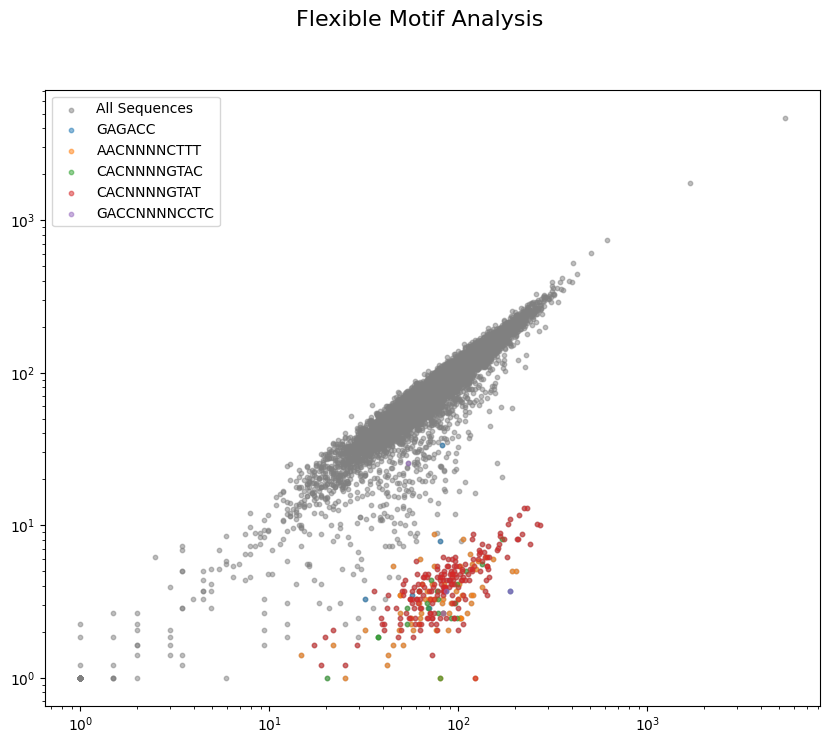

In [ ]:
plot_flexible_motif_analysis(counts, "JJ1886_T0", "MFDpir", flexible_motifs_df, left, right)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()